In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') /cm.sum(axis = 1)[:,np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print('Confusion matrix, without normalization')
  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j], fmt),
    horizontalalignment='center',
    color='white' if cm[i, j] >thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [3]:
transformer = torchvision.transforms.Compose([
  transforms.RandomCrop(32,padding =4),
  transforms.RandomHorizontalFlip(),
  transforms.RandomAffine(0, translate=(0.1,0.1)),
  transforms.ToTensor(),
])

In [4]:
train_data = torchvision.datasets.CIFAR10(
  root = '.',
  train=True,
  transform=transformer,
  download=True
)

test_data = torchvision.datasets.CIFAR10(
  root='.',
  train=False,
  transform=transforms.ToTensor(),
  download=True
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [5]:
train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
classes = len(train_data.classes)
print("%s objects to classify" % classes)

10 objects to classify


In [7]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

train_data_fix = torchvision.datasets.CIFAR10(
  root = '.',
  train=True,
  transform= transforms.ToTensor(),
  download=True
)

train_loader_fix = torch.utils.data.DataLoader(dataset= train_data_fix, batch_size = 128, shuffle=False)


Files already downloaded and verified


In [8]:
class CNN(nn.Module):
  def __init__(self, C:int):
    super(CNN, self).__init__()

    self.conv1 = nn.Sequential(
      nn.Conv2d(3,32,kernel_size=3,padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.Conv2d(32,32,kernel_size=3,padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(2)
    )

    self.conv2 = nn.Sequential(
      nn.Conv2d(32,64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.Conv2d(64,64,3,padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(2)
    )

    self.conv3 = nn.Sequential(
      nn.Conv2d(64,128,3,padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.Conv2d(128,128,3,padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(2)
    )

    self.dl1 = nn.Linear(128 * 4 * 4, 1024)
    self.dl2 = nn.Linear(1024, C)

  def forward(self, X):
    X = self.conv1(X)
    X = self.conv2(X)
    X = self.conv3(X)
    X = X.view(X.size(0), -1)
    X = F.dropout(X,0.5)
    X = F.relu(self.dl1(X))
    X = F.dropout(X, 0.2)
    X = self.dl2(X)
    return X

In [9]:
model = CNN(classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [11]:
def batch_gd(model,criterion,optimizer,train_loader,test_loader,epochs:int):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 =datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs,targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)
    
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train losses: {train_loss: .4f}, Test losses: {test_loss: .4f}, Duration: {dt}')
  return train_losses, test_losses    


In [12]:
train_losses, test_losses = batch_gd(model,criterion,optimizer,train_loader,test_loader,80)

Epoch 1/80, Train losses:  1.4246, Test losses:  1.1074, Duration: 0:00:33.182825
Epoch 2/80, Train losses:  0.9982, Test losses:  0.8949, Duration: 0:00:25.904320
Epoch 3/80, Train losses:  0.8482, Test losses:  0.8804, Duration: 0:00:25.326497
Epoch 4/80, Train losses:  0.7563, Test losses:  0.7754, Duration: 0:00:25.136769
Epoch 5/80, Train losses:  0.6937, Test losses:  0.6767, Duration: 0:00:25.296680
Epoch 6/80, Train losses:  0.6447, Test losses:  0.6497, Duration: 0:00:25.371520
Epoch 7/80, Train losses:  0.6095, Test losses:  0.6118, Duration: 0:00:25.202706
Epoch 8/80, Train losses:  0.5737, Test losses:  0.6126, Duration: 0:00:25.456332
Epoch 9/80, Train losses:  0.5465, Test losses:  0.5574, Duration: 0:00:25.176699
Epoch 10/80, Train losses:  0.5248, Test losses:  0.5641, Duration: 0:00:25.643219
Epoch 11/80, Train losses:  0.5078, Test losses:  0.5286, Duration: 0:00:25.499129
Epoch 12/80, Train losses:  0.4944, Test losses:  0.5108, Duration: 0:00:25.365111
Epoch 13/80, 

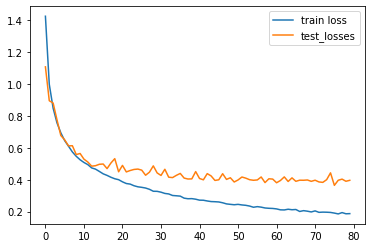

In [13]:
plt.plot(train_losses, label= 'train loss')
plt.plot(test_losses, label = 'test_losses')
plt.legend()
plt.show()

In [14]:
model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader_fix:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  _,predictions = torch.max(outputs, 1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct/n_total

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  _,predictions = torch.max(outputs, 1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
test_acc = n_correct/n_total

print(f'Train acc: {train_acc: .4f}, Test acc: {test_acc: .4f}')

Train acc:  0.9513, Test acc:  0.9402


Confusion matrix, without normalization
[[849  19  36  24  16   1   4   2  25  24]
 [  2 957   1   3   0   1   1   0   6  29]
 [ 14   1 825  43  52  16  27  14   1   7]
 [  4   4  21 828  31  74  17  11   3   7]
 [  1   0  11  30 920  10  13  14   1   0]
 [  2   1  16 135  29 794   5  16   0   2]
 [  5   3  17  36  14   9 914   1   0   1]
 [  1   2   6  26  30  31   3 897   2   2]
 [ 30  18   6  13   1   2   5   4 908  13]
 [  8  34   4   4   0   0   1   0   6 943]]


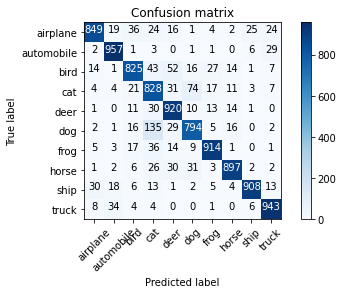

In [15]:
x_test = test_data.data
y_test = np.array(test_data.targets)
p_test = np.array([])

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  _,predictions = torch.max(outputs, 1)
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))
cm = confusion_matrix(y_test,p_test)
plot_confusion_matrix(cm,train_data.classes)

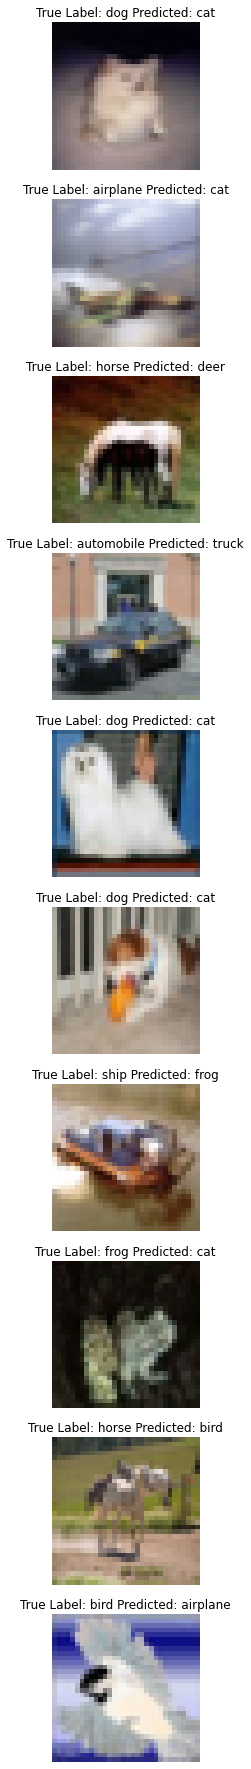

In [17]:
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
img_idx = np.random.choice(misclassified_idx, 10, replace=False)
plt.figure(figsize=(32,32))
for j, i in enumerate(img_idx):
  plt.subplot(10, 1, j+1)
  plt.axis('off')
  plt.imshow(x_test[i].reshape(32,32,3))
  plt.title("True Label: %s Predicted: %s" % (train_data.classes[y_test[i]], train_data.classes[p_test[i]]))